## Important neighobing atoms analysis

### Import Libraries

In [1]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

import copy
import yaml
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import networkx as nx
from pysmiles import read_smiles
import seaborn as sns
# from sklearn.decomposition import PCA

import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import directed_hausdorff

from src.lightning import DDPM
from src.datasets import get_dataloader
from src.visualizer import load_molecule_xyz, load_xyz_files, save_xyz_file
from src.molecule_builder import get_bond_order
from src.utils import add_partial_mean_with_mask
from src import const



In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load configuration from config.yml
with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
chains = config['CHAINS']
DATA = config['DATA']
prefix = config['PREFIX']
keep_frames = int(config['KEEP_FRAMES'])
P = config['P']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
SEED = int(config['SEED'])
REMOVAL = config['REMOVAL']
ATOM_PERTURBATION = config['ATOM_PERTURBATION']
ROTATE = config['ROTATE']
TRANSLATE = config['TRANSLATE']
REFLECT = config['REFLECT']
TRANSFORMATION_SEED = int(config['TRANSFORMATION_SEED'])
SAVE_VISUALIZATION = config['SAVE_VISUALIZATION']
M = int(config['M'])
NUM_SAMPLES = int(config['NUM_SAMPLES'])
PARALLEL_STEPS = int(config['PARALLEL_STEPS'])
TOP_K_PERTURBATION_REMOVAL = config['TOP_K_PERTURBATION_REMOVAL']
LOCAL_MINIMUM_ANALYSIS = config['LOCAL_MINIMUM_ANALYSIS']

print("Random seed: ", SEED)

experiment_name = checkpoint.split('/')[-1].replace('.ckpt', '')

assert (REMOVAL or ATOM_PERTURBATION) and not (REMOVAL and ATOM_PERTURBATION), "Either REMOVAL or ATOM_PERTURBATION must be set to True, but not both or None"

#create output directories
if REMOVAL:
    chains_output_dir = os.path.join(chains, experiment_name, prefix, 'chains_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition/atom_removal')
    final_states_output_dir = os.path.join(chains, experiment_name, prefix, 'final_states_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition/atom_removal')
elif ATOM_PERTURBATION:
    chains_output_dir = os.path.join(chains, experiment_name, prefix, 'chains_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition/atom_perturbation')
    final_states_output_dir = os.path.join(chains, experiment_name, prefix, 'final_states_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition/atom_perturbation')
else:
    chains_output_dir = os.path.join(chains, experiment_name, prefix, 'chains_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition')
    final_states_output_dir = os.path.join(chains, experiment_name, prefix, 'final_states_' + P + '_seed_' + str(SEED) + '_neighbors_analysis_COM_addition')

if TOP_K_PERTURBATION_REMOVAL:
    chains_output_dir = chains_output_dir.replace('atom', 'top_k_atom')
    final_states_output_dir = final_states_output_dir.replace('atom', 'top_k_atom')
    final_states_output_dir = final_states_output_dir.replace('atom', 'top_k_atom')

if LOCAL_MINIMUM_ANALYSIS:
    chains_output_dir = chains_output_dir.replace('atom', 'atom_local_min')
    final_states_output_dir = final_states_output_dir.replace('atom', 'atom_local_min')
    
os.makedirs(chains_output_dir, exist_ok=True)
os.makedirs(final_states_output_dir, exist_ok=True)

# Loading model form checkpoint 
model = DDPM.load_from_checkpoint(checkpoint, map_location=device)

# Possibility to evaluate on different datasets (e.g., on CASF instead of ZINC)
model.val_data_prefix = prefix

print(f"Running on device: {device}")
# In case <Anonymous> will run my model or vice versa
if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1, #@mastro, it was 32
    # batch_size=len(model.val_dataset)
)

print("Model", model)
print("Using anchors as context: ", model.anchors_context)
print("Center of mass:", model.center_of_mass)
print("Timesteps:", model.edm.T)

diffusion_steps = model.edm.T

Random seed:  42


/home/mastropietro/anaconda3/envs/diff_explainer/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically

Running on device: cuda:1
Model DDPM(
  (edm): EDM(
    (gamma): PredefinedNoiseSchedule()
    (dynamics): Dynamics(
      (dynamics): EGNN(
        (embedding): Linear(in_features=10, out_features=128, bias=True)
        (embedding_out): Linear(in_features=128, out_features=10, bias=True)
        (e_block_0): EquivariantBlock(
          (gcl_0): GCL(
            (edge_mlp): Sequential(
              (0): Linear(in_features=258, out_features=128, bias=True)
              (1): SiLU()
              (2): Linear(in_features=128, out_features=128, bias=True)
              (3): SiLU()
            )
            (node_mlp): Sequential(
              (0): Linear(in_features=256, out_features=128, bias=True)
              (1): SiLU()
              (2): Linear(in_features=128, out_features=128, bias=True)
            )
          )
          (gcl_1): GCL(
            (edge_mlp): Sequential(
              (0): Linear(in_features=258, out_features=128, bias=True)
              (1): SiLU()
          

### Set random seeds

In [3]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)
random.seed(SEED)

### Utility functions

In [4]:
def arrestomomentum():
    raise KeyboardInterrupt("Debug interrupt.")

def compute_hausdorff_distance_batch(mol1, mol2, mask1 = None, mask2 = None, project = None, projection_mask1 = None, projection_mask2 = None,node_projection_mask = None):
    """
    Compute the Hausdorff distance between two batches of molecules.
    
    Args:
        mol1 (torch.Tensor): The first batch of molecules.
        mol2 (torch.Tensor): The second batch of molecules.
        mask1 (torch.Tensor, optional): A mask indicating which atoms to consider for mol1. If not provided, all atoms will be considered.
        mask2 (torch.Tensor, optional): A mask indicating which atoms to consider for mol2. If not provided, all atoms will be considered.
        project (bool, optional): Whether to project the molecules to their mean-centered coordinates.
        
    Returns:
        list: The Hausdorff distances between the corresponding molecules in the batches.
    """
    # If fragment_mask is provided, only consider the atoms in the mask

    #take only the positions
    mol1 = mol1[:, :, :3]
    mol2 = mol2[:, :, :3]

    
    # print("Mol 2 before projection: ", mol2[0])
    if project is None:
        pass
    elif project == "origin":
        mol1 = mol1 - mol1.mean(dim=1, keepdim=True)
        mol2 = mol2 - mol2.mean(dim=1, keepdim=True)
    elif project == "com":
        assert(projection_mask1 is not None and projection_mask2 is not None)
        mol1 = add_partial_mean_with_mask(mol1, node_projection_mask, projection_mask1)
        mol2 = add_partial_mean_with_mask(mol2, node_projection_mask, projection_mask1)
    else:
        raise ValueError("Invalid projection type.") 

    
    if mask1 is not None:
        mask1 = mask1.bool()
        batch_size = mol1.shape[0]
        masked_mol1 = []
        for i in range(batch_size):
            masked_mol1.append(mol1[i, mask1[i], :])
        
        if batch_size == 1:
            mol1 = masked_mol1[0].unsqueeze(0)
        else:    
            mol1 = torch.stack(masked_mol1)
        

    if mask2 is not None:
        mask2 = mask2.bool()
        mask2 = mask2.bool()
        batch_size = mol2.shape[0]
        masked_mol2 = []
        for i in range(batch_size):
            masked_mol2.append(mol2[i, mask2[i], :])
        
        if batch_size == 1:
            mol2 = masked_mol2[0].unsqueeze(0)
        else:    
            mol2 = torch.stack(masked_mol2)

    hausdorff_distances = []
    for i in range(mol1.shape[0]):
        hausdorff_distances.append(max(directed_hausdorff(mol1[i], mol2[i])[0], directed_hausdorff(mol2[i], mol1[i])[0]))

    return hausdorff_distances

def draw_sphere_xai(ax, x, y, z, size, color, alpha):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v)) #* 0.8
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x + xs, y + ys, z + zs, rstride=2, cstride=2, color=color, alpha=alpha)

def plot_molecule_xai(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None, colors_fragment_shadow=None, draw_atom_indices = False):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=hex_bg_color,
                    alpha=alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        colors_fragment = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        if phi_values is not None and colors_fragment_shadow is None:
            phi_values_array = np.array(phi_values)
            # Calculate the gradient colors based on phi values
            cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
            norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
            colors_fragment_shadow = cmap(norm(phi_values_array))
        elif colors_fragment_shadow is not None and phi_values is None:
            colors_fragment_shadow = colors_fragment_shadow
        else:
            raise ValueError("Either phi_values or colors_fragment_shadow must be provided, not both.")
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment, edgecolors=colors_fragment_shadow, linewidths=5, rasterized=False)
        
        if draw_atom_indices == "original":
            #get fragment indices using fragment mask
            fragment_indices = np.where(fragment_mask_on_cpu == 1)[0]
            for i, txt in enumerate(fragment_indices):
                ax.text(x_fragment[i], y_fragment[i], z_fragment[i], str(txt), color='black', fontsize=15)
        
        elif draw_atom_indices is None:
            pass

        else:
            for i, txt in enumerate(draw_atom_indices[0]):
                ax.text(x_fragment[i], y_fragment[i], z_fragment[i], str(txt), color='black', fontsize=15)

        

        #draw non-fragment atoms
        colors = colors[fragment_mask_on_cpu == 0]
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha, c=colors, rasterized=False)

        if draw_atom_indices == "original":
            #get non-fragment indices using fragment mask
            non_fragment_indices = np.where(fragment_mask_on_cpu == 0)[0]
            for i, txt in enumerate(non_fragment_indices):
                ax.text(x[i], y[i], z[i], str(txt), color='black', fontsize=15)
        elif draw_atom_indices is None:
            pass
        else:
            for i, txt in enumerate(draw_atom_indices[1]):
                ax.text(x[i], y[i], z[i], str(txt), color='black', fontsize=15)

        



def plot_data3d_xai(positions, atom_type, is_geom, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1., fragment_mask=None, phi_values=None, colors_fragment_shadow=None, draw_atom_indices = False):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#000000' #'#666666'

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    plot_molecule_xai(
        ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values, colors_fragment_shadow=colors_fragment_shadow, draw_atom_indices = draw_atom_indices
    )

    max_value = positions.abs().max().item()
    axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    ax.set_zlim(-axis_lim, axis_lim)
    dpi = 300 if spheres_3d else 300 #it was 120 and 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi, transparent=True)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()

def visualize_chain_xai(
        path, spheres_3d=False, bg="black", alpha=1.0, wandb=None, mode="chain", is_geom=False, fragment_mask=None, phi_values=None, colors_fragment_shadow=None, draw_atom_indices = False
):
    files = load_xyz_files(path)
    save_paths = []

    # Fit PCA to the final molecule – to obtain the best orientation for visualization
    positions, one_hot, charges = load_molecule_xyz(files[-1], is_geom=is_geom)
    pca = PCA(n_components=3)
    pca.fit(positions)

    for i in range(len(files)):
        file = files[i]

        positions, one_hot, charges = load_molecule_xyz(file, is_geom=is_geom)
        atom_type = torch.argmax(one_hot, dim=1).numpy()

        # Transform positions of each frame according to the best orientation of the last frame
        positions = pca.transform(positions)
        positions = torch.tensor(positions)

        fn = file[:-4] + '.png'
        plot_data3d_xai(
            positions, atom_type,
            save_path=fn,
            spheres_3d=spheres_3d,
            alpha=alpha,
            bg=bg,
            camera_elev=90,
            camera_azim=90,
            is_geom=is_geom,
            fragment_mask=fragment_mask,
            phi_values=phi_values,
            colors_fragment_shadow=colors_fragment_shadow,
            draw_atom_indices = draw_atom_indices
        )
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})

### Important atom analysis

In [5]:
num_samples = NUM_SAMPLES
sampled = 0
start = 0

INTIAL_DISTIBUTION_PATH = "initial_distributions/seed_" + str(SEED)
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"

data_list = []
for data in dataloader:

    if sampled < num_samples:
        data_list.append(data)
        sampled += 1


# load initial distrubution of noisy features and positions
noisy_features = torch.load(INTIAL_DISTIBUTION_PATH + "/noisy_features_seed_" + str(SEED) + ".pt", map_location=device, weights_only=True)
noisy_positions = torch.load(INTIAL_DISTIBUTION_PATH + "/noisy_positions_seed_" + str(SEED) + ".pt", map_location=device, weights_only=True)

### Atom Perturbation/Removal

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

chain_final_frame_0_batch_before_injection shape:  torch.Size([3, 26, 11])
chain_batch_molecule_pertubation_before_injection shape:  torch.Size([3, 21, 11])
Hausdorff distances before injection:  [6.840438398272009, 6.493357001531542, 4.850219373769753]
Hausdorff distances after injection:  [9.074160176969254, 8.936734319799257, 8.664400886679946, 8.327938044512031, 8.585720907529348, 8.620678908933368, 7.787898066582476, 7.7584526724286595]
Hausdorff distances after perturbation:  [9.074160176969254, 8.936734319799257, 8.664400886679946, 8.327938044512031, 8.585720907529348, 8.620678908933368, 7.787898066582476, 7.7584526724286595, 6.840438398272009, 6.493357001531542, 4.850219373769753]
chain_batch_molecule_pertubation_before_injection shape:  torch.Size([3, 21, 11])
chain_batch_molecule_pertubation_after_injection shape:  torch.Size([8, 26, 11])


IndexError: boolean index did not match indexed array along dimension 0; dimension is 21 but corresponding boolean dimension is 26

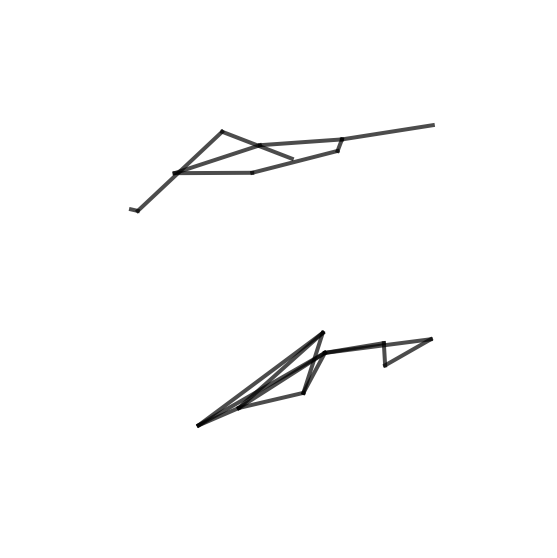

In [6]:
top_k_neighs_dict = {3:5, 4:3, 7:8, 10: 6, 13: 10, 14:5,  22: 5, 23: 9, 27: 10, 28:5, 29: 8}
num_atom_type_perturbations = 5

for data_index, data in enumerate(tqdm(data_list)):

    if data_index not in top_k_neighs_dict.keys():
        continue

    top_k_neighs = top_k_neighs_dict[data_index]

    smile = data["name"][0]
    mol = read_smiles(smile)

    noisy_positions_present_atoms = noisy_positions.clone()
    noisy_features_present_atoms = noisy_features.clone()

    noisy_positions_present_atoms = noisy_positions_present_atoms[:, :data["positions"].shape[1], :]
    noisy_features_present_atoms = noisy_features_present_atoms[:, :data["one_hot"].shape[1], :]

    num_fragment_atoms = int(data["fragment_mask"].sum().item())

    #generate sample chain using original fragment atoms
    
    # print("Original molecule positions: ", data["positions"])
    
    chain_batch_original, node_mask_original = model.sample_chain(data, keep_frames=keep_frames, noisy_positions=noisy_positions_present_atoms, noisy_features=noisy_features_present_atoms)
    
    #load Shapley values for Hausdorff distance
    phi_values = []
    
    
    with open(f"{SHAPLEY_VALUES_FOLDER}explanations_hausdorff_distance_{P}_seed_{str(SEED)}_no_transform_transformation_seed_42_COM_addition_wrong_pos/phi_atoms_{data_index}.txt", "r") as read_file:
        read_file.readline()
        read_file.readline()
        for row in read_file:
            if row.strip() == "":
                break
            line = row.strip().split(",")
            phi_values.append(float(line[1])) 

    phi_values_array = np.array(phi_values)
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    colors_fragment_shadow = cmap(norm(phi_values_array))

    #take first and only molecule
    chain_batch_original_molecule = chain_batch_original[:, 0, :, :]
    
    chain_final_frame_0 = chain_batch_original_molecule[0, :, :]
    chain_final_frame_0_batch = chain_final_frame_0.repeat(keep_frames, 1, 1)
    original_linker_mask_batch = data["linker_mask"][0].squeeze().repeat(keep_frames, 1).cpu()

    # hausdorff_distance_original = compute_hausdorff_distance_batch(chain_final_frame_0_batch.cpu(), chain_final_frame_0_batch.cpu(), mask1=original_linker_mask_batch, mask2=original_linker_mask_batch)
    
    # print("Hausdorff distance between the frame 0 and the frame 0: ", hausdorff_distance_original)
    # arrestomomentum()
    # Compute the difference between the original positions and the positions in chain_batch_original_molecule
    original_positions = data["positions"][0]
    chain_positions = chain_batch_original_molecule[0, :, :3]  # Assuming the first 3 columns are the positions

    position_differences = original_positions - chain_positions
    position_differences = position_differences[data["fragment_mask"].squeeze().bool()][0]
    
    #add position differences to the chain_positions positions
    chain_final_frame_0_batch[:, :, :3] = chain_final_frame_0_batch[:, :, :3] + position_differences
    chain_batch_original_molecule[:, :, :3] = chain_batch_original_molecule[:, :, :3] + position_differences
    
    #compute Hausdorff distance between the frame 0 and the rest of the frames
    hausdorff_distances_original = compute_hausdorff_distance_batch(chain_final_frame_0_batch.cpu(), chain_batch_original_molecule.cpu(), mask1=original_linker_mask_batch, mask2=original_linker_mask_batch) #the linker atoms are the same since those are the frames of a single molecule
    # print("Node mask original: ", node_mask_original)
    # hausdorff_distances_original_projected = compute_hausdorff_distance_batch(chain_final_frame_0_batch.cpu(), chain_batch_original_molecule.cpu(), mask1=original_linker_mask_batch, mask2=original_linker_mask_batch) #the linker atoms are the same since those are the frames of a single molecule
    # hausdorff_distances_original_projected = compute_hausdorff_distance_batch(chain_final_frame_0_batch.cpu(), chain_batch_original_molecule.cpu(), mask1=original_linker_mask_batch, mask2=original_linker_mask_batch, project="origin")
    # print("Hausdorff distances: ", hausdorff_distances_original)
    
    

    #save and visualize original chain

    for i in range(len(data['positions'])):
            chain = chain_batch_original[:, i, :, :]
            assert chain.shape[0] == keep_frames
            assert chain.shape[1] == data['positions'].shape[1]
            assert chain.shape[2] == data['positions'].shape[2] + data['one_hot'].shape[2] + model.include_charges

            # Saving chains
            name = str(i + start)
            if ATOM_PERTURBATION:
                chain_output = os.path.join(chains_output_dir, str(data_index), "original")
            elif REMOVAL:
                chain_output = os.path.join(chains_output_dir, str(data_index), "original")
            os.makedirs(chain_output, exist_ok=True)
            
            #save initial random distrubution with noise
            positions_combined = torch.zeros_like(data['positions'])
            one_hot_combined = torch.zeros_like(data['one_hot'])

            # Iterate over each atom and decide whether to use original or noisy data
            for atom_idx in range(data['positions'].shape[1]):
                if data['fragment_mask'][0, atom_idx] == 1:
                    # Use original positions and features for fragment atoms
                    positions_combined[:, atom_idx, :] = data['positions'][:, atom_idx, :]
                    one_hot_combined[:, atom_idx, :] = data['one_hot'][:, atom_idx, :]
                    # atom_mask_combined[:, atom_idx] = data['atom_mask'][:, atom_idx]
                else:
                    # Use noisy positions and features for linker atoms
                    positions_combined[:, atom_idx, :] = noisy_positions_present_atoms[:, atom_idx, :]
                    one_hot_combined[:, atom_idx, :] = noisy_features_present_atoms[:, atom_idx, :]

            #save initial distribution TODO: fix positions, they are not centered
            
            save_xyz_file(
                chain_output,
                one_hot_combined,
                positions_combined,
                node_mask_original[i].unsqueeze(0),
                names=[f'{name}_' + str(keep_frames)],
                is_geom=model.is_geom
            )

            # one_hot = chain[:, :, 3:-1]
            one_hot = chain[:, :, 3:] #@mastro, added last atom type (not sure whyt it was not included...) However, TODO check again
            positions = chain[:, :, :3]
            chain_node_mask = torch.cat([node_mask_original[i].unsqueeze(0) for _ in range(keep_frames)], dim=0)
            names = [f'{name}_{j}' for j in range(keep_frames)]

            save_xyz_file(chain_output, one_hot, positions, chain_node_mask, names=names, is_geom=model.is_geom)

            visualize_chain_xai(
                chain_output,
                spheres_3d=False,
                alpha=0.7,
                bg='white',
                is_geom=model.is_geom,
                fragment_mask=data['fragment_mask'][i].squeeze(),
                phi_values=None,
                colors_fragment_shadow=colors_fragment_shadow,
                draw_atom_indices="original"
            )

            # Saving final prediction and ground truth separately
            true_one_hot = data['one_hot'][i].unsqueeze(0)
            true_positions = data['positions'][i].unsqueeze(0)
            true_node_mask = data['atom_mask'][i].unsqueeze(0)

            #TODO chech if the final positions are saved in the correct folder
            final_states_output_dir_current = None

            if REMOVAL:
                final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "original")
            if ATOM_PERTURBATION:
                final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "original")
           
            os.makedirs(final_states_output_dir_current, exist_ok=True)
            save_xyz_file(
                final_states_output_dir_current,
                true_one_hot,
                true_positions,
                true_node_mask,
                names=[f'{name}_true'],
                is_geom=model.is_geom,
            )

            pred_one_hot = chain[0, :, 3:-1].unsqueeze(0)
            pred_positions = chain[0, :, :3].unsqueeze(0)
            pred_node_mask = chain_node_mask[0].unsqueeze(0)
            save_xyz_file(
                final_states_output_dir_current,
                pred_one_hot,
                pred_positions,
                pred_node_mask,
                names=[f'{name}_pred'],
                is_geom=model.is_geom
            )

    
    # Create a line plot for Hausdorff distances
    plt.figure(figsize=(10, 6))
    plt.gca().set_facecolor('white')
    #reverse hausdorff distances
    hausdorff_distances_original = hausdorff_distances_original[::-1]
    sns.lineplot(data=hausdorff_distances_original, marker='o')
    #plt.title('Hausdorff Distance Trend')
    plt.xlabel('Frame')
    plt.ylabel('Hausdorff Distance')
    plt.xticks(ticks=range(keep_frames), labels=range(keep_frames-1, -1, -1))  # Show all 10 frames on the x-axis
    plt.ylim(bottom=0)  # Ensure the y-axis starts at 0
    #add white background


    SAVE_PATH = f"results/plots/neighbor_analysis_COM_addition/{data_index}/"

    if ATOM_PERTURBATION:
        if TOP_K_PERTURBATION_REMOVAL:
            SAVE_PATH += "perturbation_top_k/"
        else:
            SAVE_PATH += "perturbation/"

    elif REMOVAL:
        if TOP_K_PERTURBATION_REMOVAL:
            SAVE_PATH += "removal_top_k/"
        else:
            SAVE_PATH += "removal/"

    if LOCAL_MINIMUM_ANALYSIS:
        SAVE_PATH = SAVE_PATH.replace("neighbor_analysis_COM_addition", "neighbor_analysis_COM_addition_local_min_analysis")


    os.makedirs(SAVE_PATH, exist_ok=True)

    plt.savefig(SAVE_PATH + "hausdorff_distance_trend_original.png", dpi = 300)
    plt.savefig(SAVE_PATH + "hausdorff_distance_trend_original.pdf", dpi = 300)
    
    plt.close()

    fragment_mask = data["fragment_mask"].squeeze().bool()
    linker_mask = data["linker_mask"].squeeze().bool()
    phi_values_tensor = torch.tensor(phi_values)

    #get indices of phi_values_tensor from lower to higher
    sorted_phi_values, sorted_indices = torch.sort(phi_values_tensor)
    # reversed_indices = torch.flip(sorted_indices, [0])

    #take top k neighbors
    shapley_value_indices_keep = sorted_indices[top_k_neighs:]
    top_indices_to_perturb = sorted_indices[:top_k_neighs]
    sorted_phi_values = sorted_phi_values[:top_k_neighs]
    # print("Top k neighbors: ", top_indices_to_perturb)
    # print("shapley_value_indices_keep: ", shapley_value_indices_keep)
    # #print linker atoms
    # print("Linker atoms: ", torch.where(linker_mask)[0])
    # #print fragment atoms
    # print("Fragment atoms: ", torch.where(fragment_mask)[0])
    
    for swap_num in tqdm(range(num_atom_type_perturbations)):
        # data_temp = data.copy()
        data_temp = copy.deepcopy(data)
        

        noisy_positions_present_atoms_temp = noisy_positions_present_atoms.clone()
        noisy_features_present_atoms_temp = noisy_features_present_atoms.clone()
        
    
        
        #retrieve indices of fragment and linker atoms from atom_mask
        fragment_atoms_indices = torch.where(fragment_mask)[0]
        fragment_atoms_indices = fragment_atoms_indices.to(device)
        linker_atoms_indices = torch.where(linker_mask)[0]
        linker_atoms_indices = linker_atoms_indices.to(device)
        
        # Randomly change atom type (one_hot) for the atoms at the indices top_indices_to_perturb

        if ATOM_PERTURBATION:

            if not TOP_K_PERTURBATION_REMOVAL:
                for idx in top_indices_to_perturb:
                    if data_temp["anchors"][0, idx] == 1: #we leave anchor atoms as they are since we are analyzing the neighbors
                        continue
                    current_atom_type = torch.argmax(data_temp["one_hot"][:, idx, :], dim=1, keepdim=True)
                    stop = False
                    while not stop:
                        random_atom_type = torch.randint(0, data_temp["one_hot"].shape[2], (1,), device=device)
                        if random_atom_type != current_atom_type:
                            stop = True
                    data_temp["one_hot"][:, idx, :] = 0
                    data_temp["one_hot"][:, idx, random_atom_type] = 1
            else:
                if swap_num == 0:
                    for idx in top_indices_to_perturb:
                        if data_temp["anchors"][0, idx] == 1: #we leave anchor atoms as they are since we are analyzing the neighbors
                            continue
                        current_atom_type = torch.argmax(data_temp["one_hot"][:, idx, :], dim=1, keepdim=True)
                        stop = False
                        while not stop:
                            random_atom_type = torch.randint(0, data_temp["one_hot"].shape[2], (1,), device=device)
                            if random_atom_type != current_atom_type:
                                stop = True
                        data_temp["one_hot"][:, idx, :] = 0
                        data_temp["one_hot"][:, idx, random_atom_type] = 1
                else:                    
                    num_atoms_to_perturb = min(swap_num, len(top_indices_to_perturb))
                    
                    if num_atoms_to_perturb > len(top_indices_to_perturb):
                        continue
                    else:
                        for idx in top_indices_to_perturb[:num_atoms_to_perturb]:
                            if data_temp["anchors"][0, idx] == 1:  # we leave anchor atoms as they are since we are analyzing the neighbors
                                continue
                            current_atom_type = torch.argmax(data_temp["one_hot"][:, idx, :], dim=1, keepdim=True)
                            stop = False
                            while not stop:
                                random_atom_type = torch.randint(0, data_temp["one_hot"].shape[2], (1,), device=device)
                                if random_atom_type != current_atom_type:
                                    stop = True
                            data_temp["one_hot"][:, idx, :] = 0
                            data_temp["one_hot"][:, idx, random_atom_type] = 1

    
        if REMOVAL:

            #keep only elements from fragment_atoms_indices at the indices in shapley_value_indices_keep
            fragment_atoms_indices_keep = None

            # if swap_num == 0:
            #     #no atom is removed
            #     fragment_atoms_indices_keep = fragment_atoms_indices
            if not TOP_K_PERTURBATION_REMOVAL:
                if swap_num == 0: #at the first iteration, we remove all top k and make sure anchor atoms are kept
                    fragment_atoms_indices_keep = torch.cat((shapley_value_indices_keep.to(device), torch.where(data_temp["anchors"].squeeze() == 1)[0].to(device)))
                
                else:
                    # num_atoms_to_add = min(len(top_indices_to_perturb), 3)  # Number of atoms to randomly select and add
                    num_atoms_to_add = np.random.randint(1, len(top_indices_to_perturb))
                    random_atoms_to_add = np.random.choice(top_indices_to_perturb.cpu().numpy(), num_atoms_to_add, replace=False)
                    fragment_atoms_indices_keep = torch.cat((shapley_value_indices_keep.to(device), torch.tensor(random_atoms_to_add, device=device)))
            else:
                if swap_num == 0:
                    #at the first iteration, we remove all top k and make sure anchor atoms are kept
                    fragment_atoms_indices_keep = torch.cat((shapley_value_indices_keep.to(device), torch.where(data_temp["anchors"].squeeze() == 1)[0].to(device)))
                else:
                    num_atoms_to_perturb = min(swap_num , len(top_indices_to_perturb))
                        
                    if num_atoms_to_perturb > len(top_indices_to_perturb):
                        continue
                    else:
                        fragment_atoms_indices_keep = torch.cat((shapley_value_indices_keep.to(device), top_indices_to_perturb[num_atoms_to_perturb:].to(device)))
                            
            
            #remove duplicates
            fragment_atoms_indices_keep = torch.unique(fragment_atoms_indices_keep)
                
            # print("Anchor atoms: ", torch.where(data_temp["anchors"].squeeze() == 1)[0])
            # print("fragment_atoms_indices_keep: ", fragment_atoms_indices_keep)

            # fragment_atoms_indices_keep = fragment_atoms_indices[shapley_value_indices_keep]
            fragment_atoms_indices_keep_tensor = torch.Tensor(fragment_atoms_indices_keep).to(device)
            
            #keep only fragment_atoms_indices_keep and linker_atoms_indices
            atom_indices_to_keep = torch.cat((fragment_atoms_indices_keep_tensor, linker_atoms_indices)).to(device)

            #remove atoms from molecule
            data_temp["positions"] = data_temp["positions"][:, atom_indices_to_keep, :]
            data_temp["one_hot"] = data_temp["one_hot"][:, atom_indices_to_keep, :]
            data_temp["charges"] = data_temp["charges"][:, atom_indices_to_keep]
            data_temp["fragment_mask"] = data_temp["fragment_mask"][:, atom_indices_to_keep]
            data_temp["linker_mask"] = data_temp["linker_mask"][:, atom_indices_to_keep]
            data_temp["atom_mask"] = data_temp["atom_mask"][:, atom_indices_to_keep]
            data_temp["anchors"] = data_temp["anchors"][:, atom_indices_to_keep]
            edge_mask_to_keep = (data_temp["atom_mask"].unsqueeze(1) * data_temp["atom_mask"]).flatten()
            data_temp["edge_mask"] = edge_mask_to_keep

            #remove atoms from noisy features and positions
            noisy_positions_present_atoms_temp = noisy_positions_present_atoms_temp[:, atom_indices_to_keep, :]
            noisy_features_present_atoms_temp = noisy_features_present_atoms_temp[:, atom_indices_to_keep, :]

        phi_values_array = np.array(phi_values)
        cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
        norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
        colors_fragment_shadow_original = cmap(norm(phi_values_array))
        colors_fragment_shadow = cmap(norm(phi_values_array))
        #remove atoms from color array
        molecule_perturbation_original_positions = data_temp["positions"].clone()[0]

        if REMOVAL:
            colors_fragment_shadow = colors_fragment_shadow[fragment_atoms_indices_keep.cpu().numpy()]
        
        if not LOCAL_MINIMUM_ANALYSIS:
            chain_batch, node_mask = model.sample_chain(data_temp, keep_frames=keep_frames, noisy_positions=noisy_positions_present_atoms_temp, noisy_features=noisy_features_present_atoms_temp)
        else:
            chain_before_injection, node_mask_before_injection, chain_after_injection, node_mask_after_injection = model.sample_chain_atom_injection(data_temp, keep_frames=keep_frames, noisy_positions=noisy_positions_present_atoms_temp, noisy_features=noisy_features_present_atoms_temp, orginal_data = data, noisy_positions_original = noisy_positions_present_atoms, noisy_features_original = noisy_features_present_atoms, atom_indices_kept = atom_indices_to_keep, injection_step = diffusion_steps//4)

            


        if not LOCAL_MINIMUM_ANALYSIS:
            #compute Hausdorff distance with orignal linker
            chain_batch_molecule_pertubation = chain_batch[:, 0, :, :]
        else:
            chain_batch_molecule_pertubation_before_injection = chain_before_injection[:, 0, :, :]
            chain_batch_molecule_pertubation_after_injection = chain_after_injection[:, 0, :, :]

            # Get the indices of tensors with all zero elements for the two chains
            # Remove tensors with all zero elements from chain_batch_molecule_pertubation_before_injection
            non_zero_indices_before_injection = torch.any(chain_batch_molecule_pertubation_before_injection != 0, dim=(1, 2))
            chain_batch_molecule_pertubation_before_injection = chain_batch_molecule_pertubation_before_injection[non_zero_indices_before_injection]

            # Remove tensors with all zero elements from chain_batch_molecule_pertubation_after_injection
            non_zero_indices_after_injection = torch.any(chain_batch_molecule_pertubation_after_injection != 0, dim=(1, 2))
            chain_batch_molecule_pertubation_after_injection = chain_batch_molecule_pertubation_after_injection[non_zero_indices_after_injection]

            

        mask_to_use = None
        if not LOCAL_MINIMUM_ANALYSIS:
            if REMOVAL:
                mask_to_use = data_temp["linker_mask"][0].squeeze().repeat(keep_frames, 1).cpu()
            else:
                mask_to_use = original_linker_mask_batch

            chain_perturbation_positions = chain_batch_molecule_pertubation[0, :, :3]  # Assuming the first 3 columns are the positions

            position_differences_perturb = molecule_perturbation_original_positions - chain_perturbation_positions
            position_differences_perturb = position_differences_perturb[data_temp["fragment_mask"].squeeze().bool()][0]

            chain_batch_molecule_pertubation[:, :, :3] = chain_batch_molecule_pertubation[:, :, :3] + position_differences_perturb

            hausdorff_distances_perturbation = compute_hausdorff_distance_batch(chain_final_frame_0_batch.cpu(), chain_batch_molecule_pertubation.cpu(), mask1=original_linker_mask_batch, mask2=mask_to_use) #the linker atoms are the same since those are the frames of a single molecule
        else:
            mask_to_use_before_injection = data_temp["linker_mask"][0].squeeze().repeat(keep_frames, 1).cpu()
            mask_to_use_after_injection = original_linker_mask_batch
            
            chain_perturbation_positions_before_injection = chain_batch_molecule_pertubation_before_injection[0, :, :3]  # Assuming the first 3 columns are the positions
            chain_perturbation_positions_after_injection = chain_batch_molecule_pertubation_after_injection[0, :, :3]  # Assuming the first 3 columns are the positions

            position_differences_perturb_before_injection = molecule_perturbation_original_positions - chain_perturbation_positions_before_injection
            position_differences_perturb_before_injection = position_differences_perturb_before_injection[data_temp["fragment_mask"].squeeze().bool()][0]

            position_differences_perturb_after_injection = original_positions - chain_perturbation_positions_after_injection
            position_differences_perturb_after_injection = position_differences_perturb_after_injection[data["fragment_mask"].squeeze().bool()][0]

            chain_batch_molecule_pertubation_before_injection[:, :, :3] = chain_batch_molecule_pertubation_before_injection[:, :, :3] + position_differences_perturb_before_injection
            chain_batch_molecule_pertubation_after_injection[:, :, :3] = chain_batch_molecule_pertubation_after_injection[:, :, :3] + position_differences_perturb_after_injection

            chain_final_frame_0_batch_before_injection = chain_final_frame_0.repeat(chain_batch_molecule_pertubation_before_injection.shape[0], 1, 1)
            print("chain_final_frame_0_batch_before_injection shape: ", chain_final_frame_0_batch_before_injection.shape)
            print("chain_batch_molecule_pertubation_before_injection shape: ", chain_batch_molecule_pertubation_before_injection.shape)
            hausdorff_distances_perturbation_before_injection = compute_hausdorff_distance_batch(chain_final_frame_0_batch_before_injection.cpu(), chain_batch_molecule_pertubation_before_injection.cpu(), mask1=original_linker_mask_batch, mask2=mask_to_use_before_injection) #the linker atoms are the same since those are the frames of a single molecule

            chain_final_frame_0_batch_after_injection = chain_final_frame_0.repeat(chain_batch_molecule_pertubation_after_injection.shape[0], 1, 1)
            hausdorff_distances_perturbation_after_injection = compute_hausdorff_distance_batch(chain_final_frame_0_batch_after_injection.cpu(), chain_batch_molecule_pertubation_after_injection.cpu(), mask1=original_linker_mask_batch, mask2=mask_to_use_after_injection) #the linker atoms are the same since those are the frames of a single molecule

            #the two hausdorff distance lists should be concatenated
            #TODO check if the concatenation is correct!
            hausdorff_distances_perturbation = hausdorff_distances_perturbation_after_injection + hausdorff_distances_perturbation_before_injection

            print("Hausdorff distances before injection: ", hausdorff_distances_perturbation_before_injection)
            print("Hausdorff distances after injection: ", hausdorff_distances_perturbation_after_injection)
            print("Hausdorff distances after perturbation: ", hausdorff_distances_perturbation)

            
        # print("Hausdorff distances after perturbation: ", hausdorff_distances_perturbation)
        
        
        # Create a line plot for Hausdorff distances
        plt.figure(figsize=(10, 6))
        plt.gca().set_facecolor('white')
        #reverse hausdorff distances
        hausdorff_distances_perturbation = hausdorff_distances_perturbation[::-1]
        sns.lineplot(data=hausdorff_distances_perturbation, marker='o')
        #plt.title('Hausdorff Distance Trend')
        plt.xlabel('Frame')
        plt.ylabel('Hausdorff Distance')
        plt.xticks(ticks=range(keep_frames), labels=range(keep_frames-1, -1, -1))  # Show all 10 frames on the x-axis
        plt.ylim(bottom=0)  # Ensure the y-axis starts at 0
        

        os.makedirs(SAVE_PATH, exist_ok=True)

        plt.savefig(SAVE_PATH + f"hausdorff_distance_trend_{swap_num}.png", dpi = 300)
        plt.savefig(SAVE_PATH + f"hausdorff_distance_trend_{swap_num}.pdf", dpi = 300)
        # chain_with_full_fragments = chain_batch[0, :, :, :]
        plt.close()
        #save and visualize chain (only for the linker use noisy positions for the initial distribution)
        
        if not LOCAL_MINIMUM_ANALYSIS:
            for i in range(len(data_temp['positions'])):
                chain = chain_batch[:, i, :, :]
                assert chain.shape[0] == keep_frames
                assert chain.shape[1] == data_temp['positions'].shape[1]
                assert chain.shape[2] == data_temp['positions'].shape[2] + data_temp['one_hot'].shape[2] + model.include_charges

                # Saving chains
                name = str(i + start)
                if ATOM_PERTURBATION:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "perturbation_" + str(swap_num))
                elif REMOVAL:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "removal_" + str(swap_num))
                os.makedirs(chain_output, exist_ok=True)
                
                #save initial random distrubution with noise
                positions_combined = torch.zeros_like(data_temp['positions'])
                one_hot_combined = torch.zeros_like(data_temp['one_hot'])

                # Iterate over each atom and decide whether to use original or noisy data
                for atom_idx in range(data_temp['positions'].shape[1]):
                    if data_temp['fragment_mask'][0, atom_idx] == 1:
                        # Use original positions and features for fragment atoms
                        positions_combined[:, atom_idx, :] = data_temp['positions'][:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = data_temp['one_hot'][:, atom_idx, :]
                        # atom_mask_combined[:, atom_idx] = data_temp['atom_mask'][:, atom_idx]
                    else:
                        # Use noisy positions and features for linker atoms
                        positions_combined[:, atom_idx, :] = noisy_positions_present_atoms_temp[:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = noisy_features_present_atoms_temp[:, atom_idx, :]

                #save initial distribution
            
                save_xyz_file(
                    chain_output,
                    one_hot_combined,
                    positions_combined,
                    node_mask[i].unsqueeze(0),
                    names=[f'{name}_' + str(keep_frames)],
                    is_geom=model.is_geom
                )

                # one_hot = chain[:, :, 3:-1]
                one_hot = chain[:, :, 3:] #@mastro, added last atom type (not sure whyt it was not included...) However, TODO check again
                positions = chain[:, :, :3]
                chain_node_mask = torch.cat([node_mask[i].unsqueeze(0) for _ in range(keep_frames)], dim=0)
                names = [f'{name}_{j}' for j in range(keep_frames)]

                save_xyz_file(chain_output, one_hot, positions, chain_node_mask, names=names, is_geom=model.is_geom)

                if REMOVAL:
                    draw_atom_indices = (fragment_atoms_indices_keep.tolist(), linker_atoms_indices.tolist())
                
                else:
                    draw_atom_indices = "original"

                visualize_chain_xai(
                    chain_output,
                    spheres_3d=False,
                    alpha=0.7,
                    bg='white',
                    is_geom=model.is_geom,
                    fragment_mask=data_temp['fragment_mask'][i].squeeze(),
                    phi_values=None,
                    colors_fragment_shadow=colors_fragment_shadow,
                    draw_atom_indices=draw_atom_indices
                )

                # Saving final prediction and ground truth separately
                true_one_hot = data_temp['one_hot'][i].unsqueeze(0)
                true_positions = data_temp['positions'][i].unsqueeze(0)
                true_node_mask = data_temp['atom_mask'][i].unsqueeze(0)

                #TODO chech if the final positions are saved in the correct folder
                final_states_output_dir_current = None

                if REMOVAL:
                    final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "removal_" + str(swap_num))
                if ATOM_PERTURBATION:
                    final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "perturbation_" + str(swap_num))
            
                os.makedirs(final_states_output_dir_current, exist_ok=True)
                save_xyz_file(
                    final_states_output_dir_current,
                    true_one_hot,
                    true_positions,
                    true_node_mask,
                    names=[f'{name}_true'],
                    is_geom=model.is_geom,
                )

                pred_one_hot = chain[0, :, 3:-1].unsqueeze(0)
                pred_positions = chain[0, :, :3].unsqueeze(0)
                pred_node_mask = chain_node_mask[0].unsqueeze(0)
                save_xyz_file(
                    final_states_output_dir_current,
                    pred_one_hot,
                    pred_positions,
                    pred_node_mask,
                    names=[f'{name}_pred'],
                    is_geom=model.is_geom
                )

        else:
            for i in range(len(data_temp['positions'])):
                # chain_before_injection = chain_batch_molecule_pertubation_before_injection[:, i, :, :]
                # assert chain_batch_molecule_pertubation_before_injection.shape[0] == keep_frames - diffusion_steps//4 + 1
                print("chain_batch_molecule_pertubation_before_injection shape: ", chain_batch_molecule_pertubation_before_injection.shape)
                assert chain_batch_molecule_pertubation_before_injection.shape[1] == data_temp['positions'].shape[1]
                assert chain_batch_molecule_pertubation_before_injection.shape[2] == data_temp['positions'].shape[2] + data_temp['one_hot'].shape[2] + model.include_charges

                # Saving chains
                name = str(i + start)
                if ATOM_PERTURBATION:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "perturbation_" + str(swap_num))
                elif REMOVAL:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "removal_" + str(swap_num))
                os.makedirs(chain_output, exist_ok=True)
                
                #save initial random distrubution with noise
                positions_combined = torch.zeros_like(data_temp['positions'])
                one_hot_combined = torch.zeros_like(data_temp['one_hot'])

                # Iterate over each atom and decide whether to use original or noisy data
                for atom_idx in range(data_temp['positions'].shape[1]):
                    if data_temp['fragment_mask'][0, atom_idx] == 1:
                        # Use original positions and features for fragment atoms
                        positions_combined[:, atom_idx, :] = data_temp['positions'][:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = data_temp['one_hot'][:, atom_idx, :]
                    else:
                        # Use noisy positions and features for linker atoms
                        positions_combined[:, atom_idx, :] = noisy_positions_present_atoms_temp[:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = noisy_features_present_atoms_temp[:, atom_idx, :]

                #save initial distribution

                save_xyz_file(
                    chain_output,
                    one_hot_combined,
                    positions_combined,
                    node_mask_before_injection[i].unsqueeze(0),
                    names=[f'{name}_' + str(keep_frames)],
                    is_geom=model.is_geom
                )

                # one_hot = chain[:, :, 3:-1]
                one_hot_before_injection = chain_batch_molecule_pertubation_before_injection[:, :, 3:]
                positions_before_injection = chain_batch_molecule_pertubation_before_injection[:, :, :3]
                chain_node_mask_before_injection = torch.cat([node_mask_before_injection[i].unsqueeze(0) for _ in range(chain_batch_molecule_pertubation_before_injection.shape[0])], dim=0)
                names_before_injection = [f'{name}_{j}' for j in range(chain_batch_molecule_pertubation_before_injection.shape[0])]

                save_xyz_file(chain_output, one_hot_before_injection, positions_before_injection, chain_node_mask_before_injection, names=names_before_injection, is_geom=model.is_geom)

                if REMOVAL:
                    draw_atom_indices = (fragment_atoms_indices_keep.tolist(), linker_atoms_indices.tolist())
                
                else:
                    draw_atom_indices = "original"

                visualize_chain_xai(
                    chain_output,
                    spheres_3d=False,
                    alpha=0.7,
                    bg='white',
                    is_geom=model.is_geom,
                    fragment_mask=data_temp['fragment_mask'][i].squeeze(),
                    phi_values=None,
                    colors_fragment_shadow=colors_fragment_shadow,
                    draw_atom_indices=draw_atom_indices
                )

            
            #save for after injection
            for i in range(len(data["positions"])):

                # chain_after_injection = chain_after_injection[:, i, :, :]
                # assert chain_batch_molecule_pertubation_after_injection.shape[0] == keep_frames
                print("chain_batch_molecule_pertubation_after_injection shape: ", chain_batch_molecule_pertubation_after_injection.shape)
                assert chain_batch_molecule_pertubation_after_injection.shape[1] == data["positions"].shape[1]
                assert chain_batch_molecule_pertubation_after_injection.shape[2] == data["positions"].shape[2] + data["one_hot"].shape[2] + model.include_charges

                # Saving chains
                name = str(i + start)
                if ATOM_PERTURBATION:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "perturbation_" + str(swap_num))
                elif REMOVAL:
                    chain_output = os.path.join(chains_output_dir, str(data_index), "removal_" + str(swap_num))
                os.makedirs(chain_output, exist_ok=True)
                
                #save initial random distrubution with noise
                positions_combined = torch.zeros_like(data['positions'])
                one_hot_combined = torch.zeros_like(data['one_hot'])

                # Iterate over each atom and decide whether to use original or noisy data
                for atom_idx in range(data['positions'].shape[1]):
                    if data['fragment_mask'][0, atom_idx] == 1:
                        # Use original positions and features for fragment atoms
                        positions_combined[:, atom_idx, :] = data['positions'][:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = data['one_hot'][:, atom_idx, :]
                    else:
                        # Use noisy positions and features for linker atoms
                        positions_combined[:, atom_idx, :] = noisy_positions_present_atoms[:, atom_idx, :]
                        one_hot_combined[:, atom_idx, :] = noisy_features_present_atoms[:, atom_idx, :]

                
                one_hot_after_injection = chain_batch_molecule_pertubation_after_injection[:, :, 3:]
                positions_after_injection = chain_batch_molecule_pertubation_after_injection[:, :, :3]
                chain_node_mask_after_injection = torch.cat([node_mask_after_injection[i].unsqueeze(0) for _ in range(chain_batch_molecule_pertubation_after_injection.shape[0])], dim=0)
                names_after_injection = [f'{name}_{j}' for j in range(chain_batch_molecule_pertubation_after_injection.shape[0])]

                save_xyz_file(chain_output, one_hot_after_injection, positions_after_injection, chain_node_mask_after_injection, names=names_after_injection, is_geom=model.is_geom)


                visualize_chain_xai(
                    chain_output,
                    spheres_3d=False,
                    alpha=0.7,
                    bg='white',
                    is_geom=model.is_geom,
                    fragment_mask=data['fragment_mask'][i].squeeze(),
                    phi_values=None,
                    colors_fragment_shadow=colors_fragment_shadow_original,
                    draw_atom_indices="original"
                )

                # Saving final prediction and ground truth separately
                true_one_hot = data['one_hot'][i].unsqueeze(0)
                true_positions = data['positions'][i].unsqueeze(0)
                true_node_mask = data['atom_mask'][i].unsqueeze(0)

                
                final_states_output_dir_current = None

                if REMOVAL:
                    final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "removal_" + str(swap_num))
                if ATOM_PERTURBATION:
                    final_states_output_dir_current = os.path.join(final_states_output_dir, str(data_index), "perturbation_" + str(swap_num))
            
                os.makedirs(final_states_output_dir_current, exist_ok=True)
                save_xyz_file(
                    final_states_output_dir_current,
                    true_one_hot,
                    true_positions,
                    true_node_mask,
                    names=[f'{name}_true'],
                    is_geom=model.is_geom,
                )

                pred_one_hot = chain_batch_molecule_pertubation_after_injection[0, :, 3:-1].unsqueeze(0)
                pred_positions = chain_batch_molecule_pertubation_after_injection[0, :, :3].unsqueeze(0)
                pred_node_mask = chain_batch_molecule_pertubation_after_injection[0].unsqueeze(0)

                save_xyz_file(
                    final_states_output_dir_current,
                    pred_one_hot,
                    pred_positions,
                    pred_node_mask,
                    names=[f'{name}_pred'],
                    is_geom=model.is_geom
                )

            arrestomomentum()   
        del data_temp
        del noisy_features_present_atoms_temp
        del noisy_positions_present_atoms_temp
    start += len(data['positions'])